# Mini-projet – Ensemble Learning (2025)

Ce notebook implémente les parties A et B du sujet:
- A: Chargement des données, split 70/30, analyses rapides et visualisations.
- B: Classification binaire avec arbre (Random Search) et AdaBoost (courbes, sélection, importances, temps).


In [29]:
# Optionnel: installer les dépendances manquantes (exécuter si besoin)
# Les magics %pip fonctionnent dans Jupyter et isolent l'environnement du kernel.
# Décommentez si nécessaire.
# %pip install -q pandas numpy scikit-learn matplotlib seaborn openpyxl imbalanced-learn


In [30]:
import warnings
warnings.filterwarnings("ignore")

import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)


## Partie A — Données: chargement, split, analyses rapides


In [31]:
# 1) Chargement du fichier Excel
path = r"C:\Users\sivas\Documents\Mini_Porjet_ML\Mini projet ensemble learning 2025\beer_quality.xlsx"
df = pd.read_excel(path)

# 2) Informations générales
n_rows, n_cols = df.shape
print("=== INFORMATIONS GÉNÉRALES ===")
print(f"Nombre de lignes : {n_rows}")
print(f"Nombre de colonnes : {n_cols}")
print("Colonnes :", list(df.columns))

# 3) Séparation X / y
y_col = "quality"
if y_col not in df.columns:
    raise ValueError("La colonne cible 'quality' est introuvable.")
X = df.drop(columns=[y_col])
y = df[y_col]

# 4) Split 70/30 (stratification grossière via binning sur y)
y_bins = pd.cut(y, bins=np.linspace(y.min(), y.max(), 6), include_lowest=True, right=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y_bins
)
print("\n=== SPLIT DES DONNÉES ===")
print(f"Taille X_train : {X_train.shape}")
print(f"Taille X_test  : {X_test.shape}")


=== INFORMATIONS GÉNÉRALES ===
Nombre de lignes : 1599
Nombre de colonnes : 12
Colonnes : ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

=== SPLIT DES DONNÉES ===
Taille X_train : (1119, 11)
Taille X_test  : (480, 11)


In [32]:
# 5) Statistiques descriptives et distributions
print("\n=== STATISTIQUES DESCRIPTIVES (X_train) ===")
display(X_train.describe().T)

print("\n=== DISTRIBUTION DE y_train ===")
print(y_train.value_counts().sort_index())

print("\n=== DISTRIBUTION DE y_test ===")
print(y_test.value_counts().sort_index())

# 6) Corrélations avec la cible
corr_with_y = X_train.copy()
corr_with_y["quality"] = y_train.values
corr_series = corr_with_y.corr(numeric_only=True)["quality"].drop(labels=["quality"]).sort_values(ascending=False)
print("\n=== CORRÉLATION AVEC LA VARIABLE CIBLE ===")
print(corr_series)

print("\nTop 5 corrélations positives :")
print(corr_series.head(5))
print("\nTop 5 corrélations négatives :")
print(corr_series.tail(5))



=== STATISTIQUES DESCRIPTIVES (X_train) ===


,count,mean,std,min,25%,50%,75%,max
fixed acidity,1119.0,8.328686,1.702142,4.60000,7.20000,7.90000,9.3000,15.90000
volatile acidity,1119.0,0.529406,0.179432,0.12000,0.39250,0.53000,0.6350,1.58000
citric acid,1119.0,0.273494,0.194316,0.00000,0.10000,0.26000,0.4300,0.79000
residual sugar,1119.0,2.532887,1.367640,0.90000,1.90000,2.20000,2.6000,15.40000
chlorides,1119.0,0.088022,0.048083,0.01200,0.07000,0.07900,0.0905,0.61100
free sulfur dioxide,1119.0,16.192583,10.410288,1.00000,7.00000,14.00000,22.0000,68.00000
total sulfur dioxide,1119.0,47.302949,33.534383,6.00000,22.00000,39.00000,64.0000,289.00000
density,1119.0,0.996757,0.001832,0.99007,0.99561,0.99675,0.9978,1.00369
pH,1119.0,3.309383,0.149719,2.86000,3.21000,3.31000,3.4000,3.90000
sulphates,1119.0,0.662359,0.173035,0.39000,0.55000,0.62000,0.7400,1.98000



=== DISTRIBUTION DE y_train ===
quality
3      9
4     35
5    477
6    446
7    139
8     13
Name: count, dtype: int64

=== DISTRIBUTION DE y_test ===
quality
3      1
4     18
5    204
6    192
7     60
8      5
Name: count, dtype: int64

=== CORRÉLATION AVEC LA VARIABLE CIBLE ===
alcohol                 0.477378
sulphates               0.238821
citric acid             0.200748
fixed acidity           0.103206
residual sugar          0.020868
free sulfur dioxide    -0.039430
pH                     -0.060912
chlorides              -0.122136
density                -0.180357
total sulfur dioxide   -0.188382
volatile acidity       -0.375956
Name: quality, dtype: float64

Top 5 corrélations positives :
alcohol           0.477378
sulphates         0.238821
citric acid       0.200748
fixed acidity     0.103206
residual sugar    0.020868
Name: quality, dtype: float64

Top 5 corrélations négatives :
pH                     -0.060912
chlorides              -0.122136
density                -0.1

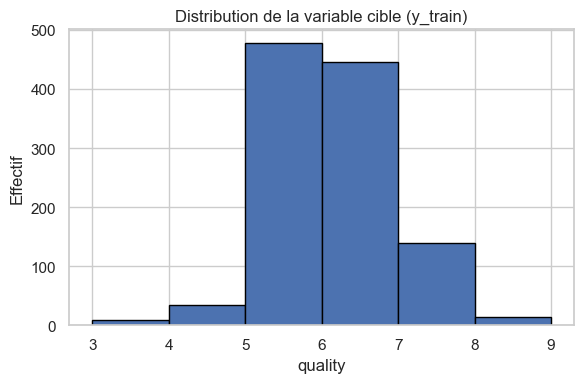

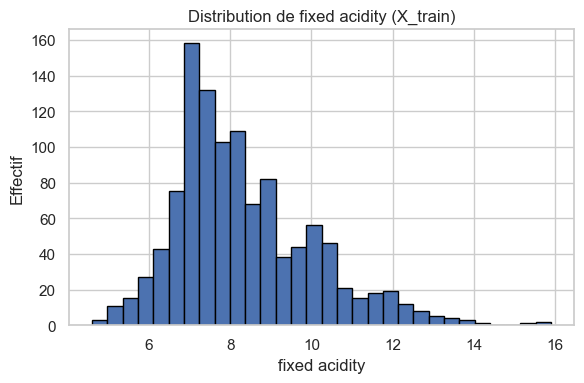

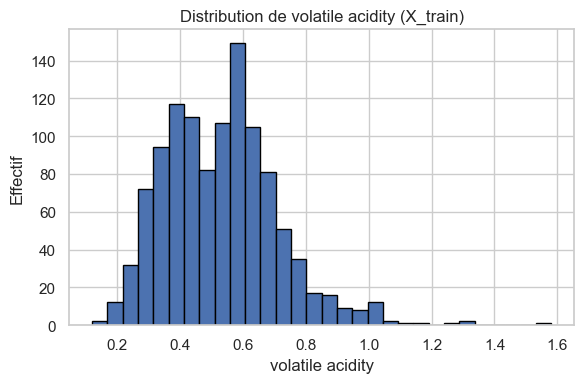

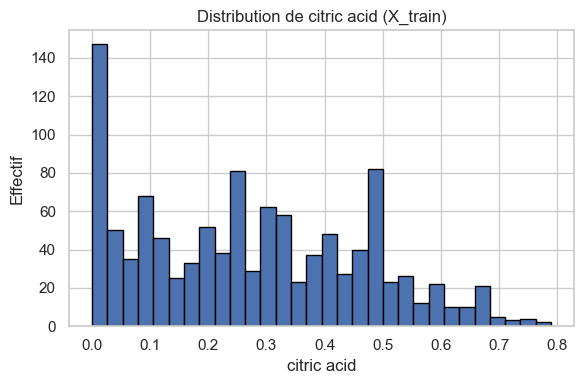

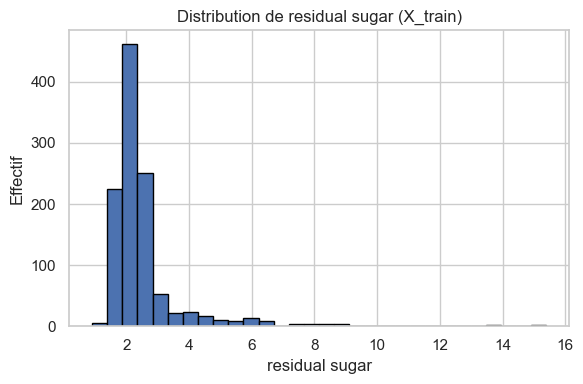

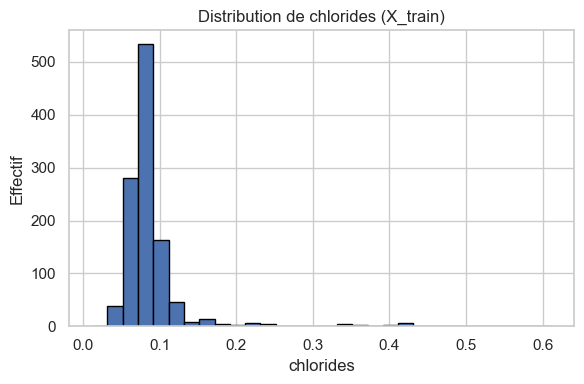

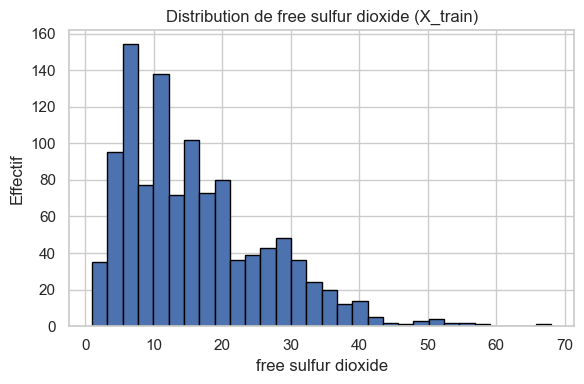

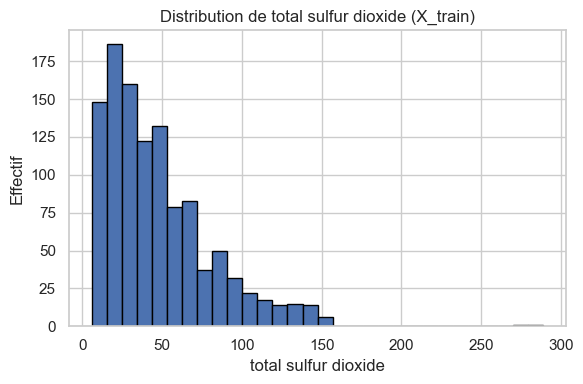

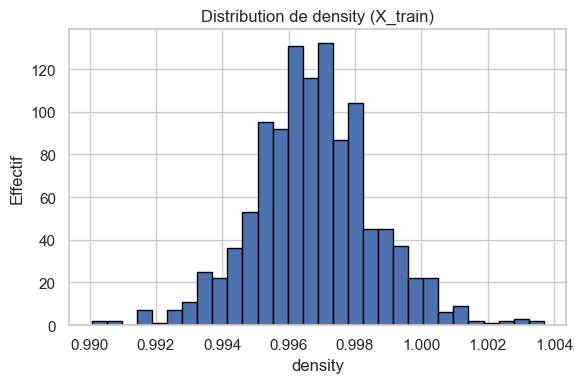

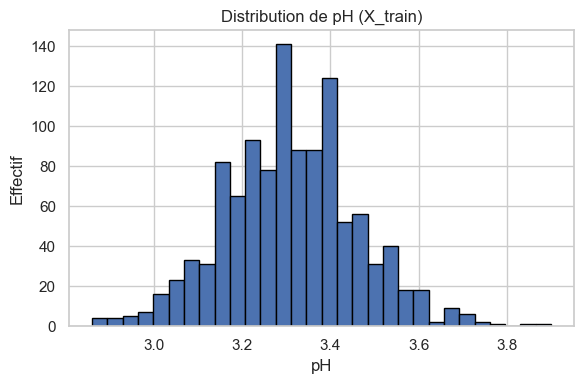

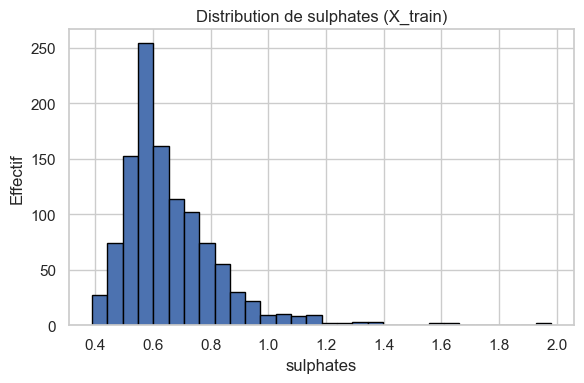

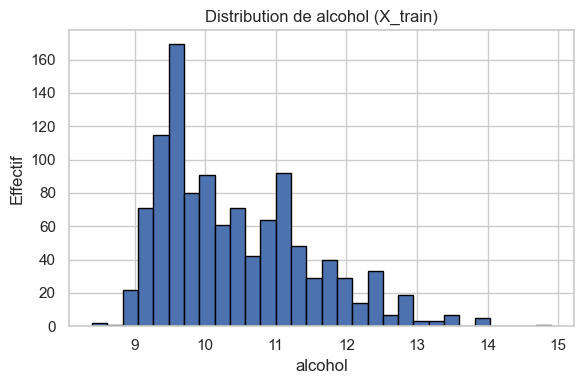

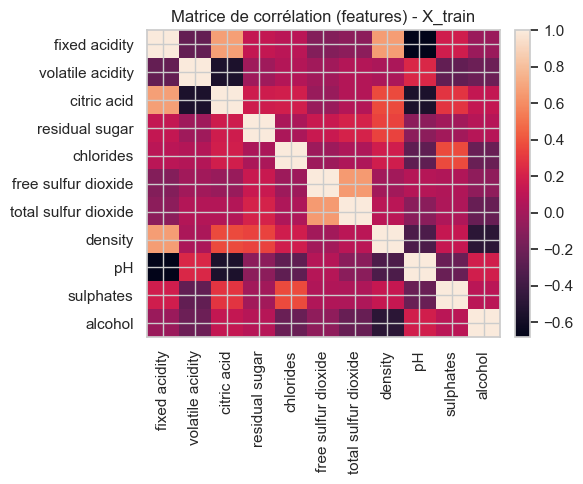

In [33]:
# 7) Visualisations de base
fig, ax = plt.subplots()
ax.hist(y_train, bins=range(int(y.min()), int(y.max()) + 2), edgecolor="black")
ax.set_title("Distribution de la variable cible (y_train)")
ax.set_xlabel("quality")
ax.set_ylabel("Effectif")
plt.tight_layout()
plt.show()

# Histogrammes des features
for col in X_train.columns:
    if is_numeric_dtype(X_train[col]):
        fig, ax = plt.subplots()
        ax.hist(X_train[col].dropna(), bins=30, edgecolor="black")
        ax.set_title(f"Distribution de {col} (X_train)")
        ax.set_xlabel(col)
        ax.set_ylabel("Effectif")
        plt.tight_layout()
        plt.show()

# Matrice de corrélations
corr_matrix = X_train.corr(numeric_only=True)
plt.figure(figsize=(6, 5))
im = plt.imshow(corr_matrix, aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(ticks=range(len(corr_matrix.columns)), labels=corr_matrix.columns, rotation=90)
plt.yticks(ticks=range(len(corr_matrix.index)), labels=corr_matrix.index)
plt.title("Matrice de corrélation (features) - X_train")
plt.tight_layout()
plt.show()


## Partie B — Classification binaire (médiane)


In [34]:
# 1) Création de ybin à partir de la médiane (calculée sur y_train)
m = y_train.median()
print(f"Médiane m = {m:.3f}")

ybin_train = (y_train >= m).astype(int)
ybin_test = (y_test >= m).astype(int)
print("\nRépartition ybin_train :")
print(ybin_train.value_counts().sort_index())
print("\nRépartition ybin_test :")
print(ybin_test.value_counts().sort_index())


Médiane m = 6.000

Répartition ybin_train :
quality
0    521
1    598
Name: count, dtype: int64

Répartition ybin_test :
quality
0    223
1    257
Name: count, dtype: int64


In [35]:
# 2) Optimisation rapide d'un arbre de décision (RandomizedSearchCV)
dt = DecisionTreeClassifier(random_state=42)
param_dist = {
    "max_depth": [None] + list(range(1, 11)),
    "min_samples_split": [2, 5, 10, 20, 50],
    "min_samples_leaf": [1, 2, 5, 10, 20],
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
}
rs = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=40,
    scoring="accuracy",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

start = time.perf_counter()
rs.fit(X_train, ybin_train)
train_time_tree = time.perf_counter() - start

best_tree = rs.best_estimator_
start = time.perf_counter()
ybin_pred_test_tree = best_tree.predict(X_test)
infer_time_tree = time.perf_counter() - start
acc_test_tree = accuracy_score(ybin_test, ybin_pred_test_tree)

print("=== Arbre de décision optimisé ===")
print("Meilleurs hyperparamètres :", rs.best_params_)
print(f"Temps apprentissage : {train_time_tree:.3f}s | Temps inférence : {infer_time_tree:.3f}s")
print(f"Accuracy test : {acc_test_tree:.4f}")

# Export LaTeX: résumé du meilleur modèle (pour \input{src/input/table_dt_randomsearch})
os.makedirs("src/input", exist_ok=True)
best_summary = pd.DataFrame([
    {
        "max_depth": rs.best_params_.get("max_depth"),
        "min_samples_split": rs.best_params_.get("min_samples_split"),
        "min_samples_leaf": rs.best_params_.get("min_samples_leaf"),
        "criterion": rs.best_params_.get("criterion"),
        "splitter": rs.best_params_.get("splitter"),
        "accuracy_test": acc_test_tree,
        "train_time_s": train_time_tree,
        "infer_time_s": infer_time_tree,
    }
])
display(best_summary)
best_summary.to_latex("src/input/table_dt_randomsearch.tex", index=False, float_format="%.4f")


Fitting 5 folds for each of 40 candidates, totalling 200 fits
=== Arbre de décision optimisé ===
Meilleurs hyperparamètres : {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 10, 'criterion': 'entropy'}
Temps apprentissage : 0.254s | Temps inférence : 0.002s
Accuracy test : 0.6937


,max_depth,min_samples_split,min_samples_leaf,criterion,splitter,accuracy_test,train_time_s,infer_time_s
0,10,10,10,entropy,best,0.69375,0.254374,0.001681


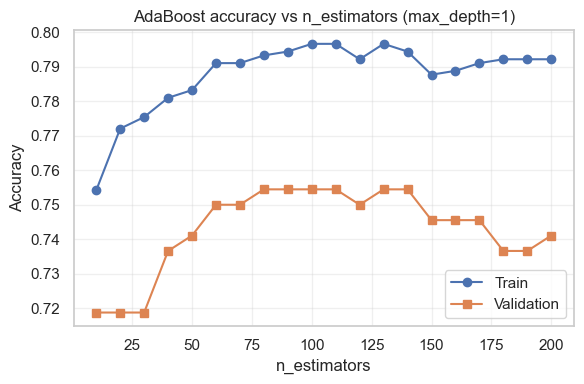

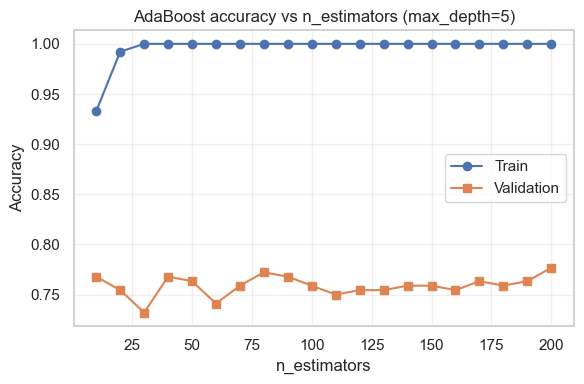

In [36]:
# 3) AdaBoost: courbes accuracy vs n_estimators (train/validation)
X_tr, X_val, ybin_tr, ybin_val = train_test_split(
    X_train, ybin_train, test_size=0.2, random_state=42, stratify=ybin_train
)

def evaluate_adaboost_over_n_estimators(max_depth_value):
    ns = list(range(10, 201, 10))
    train_accs, val_accs = [], []
    for n in ns:
        base = DecisionTreeClassifier(max_depth=max_depth_value, random_state=42)
        model = AdaBoostClassifier(
            estimator=base, n_estimators=n, algorithm="SAMME", random_state=42
        )
        model.fit(X_tr, ybin_tr)
        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)
        train_accs.append(accuracy_score(ybin_tr, y_tr_pred))
        val_accs.append(accuracy_score(ybin_val, y_val_pred))
    return ns, train_accs, val_accs

for depth in [1, 5]:
    ns, tr, va = evaluate_adaboost_over_n_estimators(depth)
    plt.figure()
    plt.plot(ns, tr, label="Train", marker="o")
    plt.plot(ns, va, label="Validation", marker="s")
    plt.xlabel("n_estimators")
    plt.ylabel("Accuracy")
    plt.title(f"AdaBoost accuracy vs n_estimators (max_depth={depth})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


Config optimale: {'max_depth': 5, 'n_estimators': 200} | Accuracy validation: 0.7768

=== AdaBoost (final) ===
Temps apprentissage : 0.837s | Temps inférence : 0.034s
Accuracy test : 0.8021


,max_depth,n_estimators,accuracy_val,accuracy_test,train_time_s,infer_time_s
0,5,200,0.776786,0.802083,0.837103,0.034062



=== Importance des variables (AdaBoost) ===


total sulfur dioxide    0.107441
density                 0.105778
chlorides               0.102635
pH                      0.098377
volatile acidity        0.094320
sulphates               0.094187
alcohol                 0.093426
fixed acidity           0.082115
residual sugar          0.077687
citric acid             0.077236
free sulfur dioxide     0.066798
dtype: float64

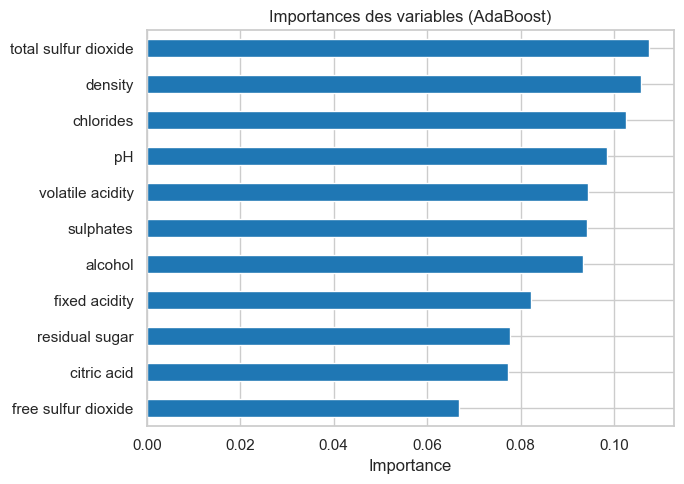


Biais/Variance:
- max_depth=1: apprenants très faibles -> biais élevé, variance faible
- max_depth=5: plus expressifs -> biais plus faible, variance plus élevée
AdaBoost réduit le biais en agrégeant de nombreux faibles apprenants, mais peut être sensible au bruit.


In [37]:
# Sélection du meilleur modèle AdaBoost sur validation, puis fit complet et test
best_score, best_cfg, best_model = -np.inf, None, None
for depth in [1, 5]:
    for n in range(10, 201, 10):
        base = DecisionTreeClassifier(max_depth=depth, random_state=42)
        model = AdaBoostClassifier(
            estimator=base, n_estimators=n, algorithm="SAMME", random_state=42
        )
        model.fit(X_tr, ybin_tr)
        val_acc = accuracy_score(ybin_val, model.predict(X_val))
        if val_acc > best_score:
            best_score = val_acc
            best_cfg = {"max_depth": depth, "n_estimators": n}
            best_model = model

print("Config optimale:", best_cfg, f"| Accuracy validation: {best_score:.4f}")

# Entraînement final sur tout X_train et évaluation test + temps
start = time.perf_counter()
final_base = DecisionTreeClassifier(max_depth=best_cfg["max_depth"], random_state=42)
final_ada = AdaBoostClassifier(
    estimator=final_base,
    n_estimators=best_cfg["n_estimators"],
    algorithm="SAMME",
    random_state=42,
)
final_ada.fit(X_train, ybin_train)
train_time_ada = time.perf_counter() - start

start = time.perf_counter()
y_test_pred_ada = final_ada.predict(X_test)
infer_time_ada = time.perf_counter() - start
acc_test_ada = accuracy_score(ybin_test, y_test_pred_ada)

print("\n=== AdaBoost (final) ===")
print(f"Temps apprentissage : {train_time_ada:.3f}s | Temps inférence : {infer_time_ada:.3f}s")
print(f"Accuracy test : {acc_test_ada:.4f}")

# Export LaTeX du meilleur modèle AdaBoost (pour \input{src/input/table_adaboost_best})
os.makedirs("src/input", exist_ok=True)
ada_summary = pd.DataFrame([
    {
        "max_depth": best_cfg["max_depth"],
        "n_estimators": best_cfg["n_estimators"],
        "accuracy_val": best_score,
        "accuracy_test": acc_test_ada,
        "train_time_s": train_time_ada,
        "infer_time_s": infer_time_ada,
    }
])
display(ada_summary)
ada_summary.to_latex("src/input/table_adaboost_best.tex", index=False, float_format="%.4f")

# Importances de variables si disponibles
if hasattr(final_ada, "feature_importances_"):
    importances = pd.Series(final_ada.feature_importances_, index=X_train.columns)
    importances = importances.sort_values(ascending=False)
    print("\n=== Importance des variables (AdaBoost) ===")
    display(importances)
    # Figure: barres horizontales et export PNG pour LaTeX
    os.makedirs("src/input", exist_ok=True)
    fig, ax = plt.subplots(figsize=(7, 5))
    importances.sort_values().plot(kind="barh", ax=ax, color="tab:blue")
    ax.set_title("Importances des variables (AdaBoost)")
    ax.set_xlabel("Importance")
    plt.tight_layout()
    plt.savefig("src/input/fig_adaboost_feature_importances.png", dpi=150)
    plt.show()
else:
    print("\nAdaBoost ne fournit pas d'importance de variables dans cette configuration.")

print("\nBiais/Variance:")
print("- max_depth=1: apprenants très faibles -> biais élevé, variance faible")
print("- max_depth=5: plus expressifs -> biais plus faible, variance plus élevée")
print("AdaBoost réduit le biais en agrégeant de nombreux faibles apprenants, mais peut être sensible au bruit.")


## Partie C — Classification multiclasse (3 classes)


In [38]:
# 1) Création de ymulti (3 classes) à partir de seuils fixes
# Seuils fixes: 0: y <= 5, 1: y == 6, 2: y >= 7
print("Seuils fixes (y): 0: y<=5, 1: y==6, 2: y>=7")

def to_ymulti_fixed(s):
    out = pd.Series(index=s.index, dtype=int)
    out[s <= 5] = 0
    out[s == 6] = 1
    out[s >= 7] = 2
    return out

ymulti_train = to_ymulti_fixed(y_train)
ymulti_test  = to_ymulti_fixed(y_test)

print("\nEffectifs (ymulti_train):")
print(ymulti_train.value_counts().sort_index())
print("\nEffectifs (ymulti_test):")
print(ymulti_test.value_counts().sort_index())

# Export LaTeX des effectifs (avant équilibrage)
os.makedirs("src/input", exist_ok=True)
counts_before = pd.DataFrame({
    "classe": [0, 1, 2],
    "train": ymulti_train.value_counts().sort_index().reindex([0,1,2]).values,
    "test": ymulti_test.value_counts().sort_index().reindex([0,1,2]).values,
})
display(counts_before)
counts_before.to_latex("src/input/table_ymulti_counts.tex", index=False)


Seuils fixes (y): 0: y<=5, 1: y==6, 2: y>=7

Effectifs (ymulti_train):
0.0    521
1.0    446
2.0    152
Name: count, dtype: int64

Effectifs (ymulti_test):
0.0    223
1.0    192
2.0     65
Name: count, dtype: int64


,classe,train,test
0,0,521,223
1,1,446,192
2,2,152,65


In [39]:
# 2) Équilibrage des classes sur l'apprentissage (SMOTE)
# On applique SMOTE uniquement sur (X_train, ymulti_train)
# Attention: SMOTE nécessite >= k_neighbors+1 exemples par classe; si problème, baisser k_neighbors.
smote = SMOTE(random_state=42)
X_train_sm, ymulti_train_sm = smote.fit_resample(X_train, ymulti_train)

print("Effectifs après SMOTE (apprentissage):")
print(pd.Series(ymulti_train_sm).value_counts().sort_index())

# Export LaTeX des effectifs équilibrés
counts_after = pd.DataFrame({
    "classe": [0, 1, 2],
    "train_SMOTE": pd.Series(ymulti_train_sm).value_counts().sort_index().reindex([0,1,2]).values,
})
display(counts_after)
counts_after.to_latex("src/input/table_ymulti_counts_balanced.tex", index=False)


Effectifs après SMOTE (apprentissage):
0.0    521
1.0    521
2.0    521
Name: count, dtype: int64


,classe,train_SMOTE
0,0,521
1,1,521
2,2,521


### Partie1C — Réseau de neurones (1 couche cachée), early stopping, F1-macro, matrices de confusion


Meilleur MLP (déséquilibré): {'hidden_layer_sizes': (64,), 'alpha': 0.0001, 'learning_rate_init': 0.001, 'note': 'imbalanced'} | F1-macro val: 0.3925327812284334
Meilleur MLP (SMOTE): {'hidden_layer_sizes': (32, 16), 'alpha': 0.0001, 'learning_rate_init': 0.001, 'note': 'SMOTE'} | F1-macro val: 0.4381328420789136

=== MLP imbalanced — Test ===
F1-macro: 0.36955334390904654


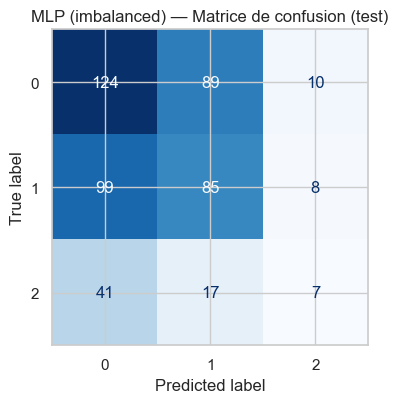


=== MLP SMOTE — Test ===
F1-macro: 0.36349765746125157


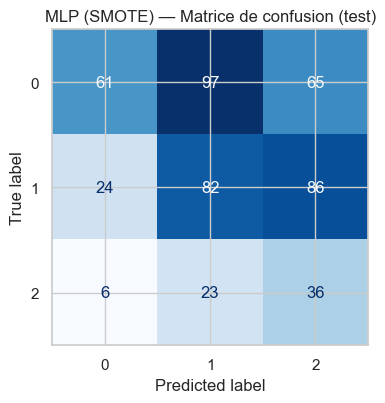

In [40]:
# Split validation pour la sélection des hyperparamètres (déséquilibré)
X_tr_m, X_val_m, y_tr_m, y_val_m = train_test_split(
    X_train, ymulti_train, test_size=0.2, random_state=42, stratify=ymulti_train
)

# Split validation pour les données équilibrées (SMOTE)
X_tr_sm, X_val_sm, y_tr_sm, y_val_sm = train_test_split(
    X_train_sm, ymulti_train_sm, test_size=0.2, random_state=42, stratify=ymulti_train_sm
)

# Recherche rapide d'hyperparamètres (F1-macro) avec early stopping
param_grid = [
    {"hidden_layer_sizes": [(32,), (64,), (32,16)], "alpha": [1e-4, 1e-3], "learning_rate_init": [1e-3, 5e-4]},
]

def tune_mlp(X_tr, y_tr, X_val, y_val, note):
    best_score, best_cfg, best_model = -np.inf, None, None
    for hls in [(32,), (64,), (32,16)]:
        for alpha in [1e-4, 1e-3]:
            for lr in [1e-3, 5e-4]:
                clf = MLPClassifier(
                    hidden_layer_sizes=hls,
                    activation="relu",
                    solver="adam",
                    alpha=alpha,
                    learning_rate_init=lr,
                    early_stopping=True,
                    n_iter_no_change=10,
                    max_iter=400,
                    random_state=42,
                )
                clf.fit(X_tr, y_tr)
                f1_val = f1_score(y_val, clf.predict(X_val), average="macro")
                if f1_val > best_score:
                    best_score = f1_val
                    best_cfg = {"hidden_layer_sizes": hls, "alpha": alpha, "learning_rate_init": lr, "note": note}
                    best_model = clf
    return best_score, best_cfg, best_model

f1_imb, cfg_imb, mlp_imb = tune_mlp(X_tr_m, y_tr_m, X_val_m, y_val_m, note="imbalanced")
f1_bal, cfg_bal, mlp_bal = tune_mlp(X_tr_sm, y_tr_sm, X_val_sm, y_val_sm, note="SMOTE")

print("Meilleur MLP (déséquilibré):", cfg_imb, "| F1-macro val:", f1_imb)
print("Meilleur MLP (SMOTE):", cfg_bal, "| F1-macro val:", f1_bal)

# Évaluation finale sur test pour les deux cas
for name, model in [("imbalanced", mlp_imb), ("SMOTE", mlp_bal)]:
    y_pred_test = model.predict(X_test)
    print(f"\n=== MLP {name} — Test ===")
    print("F1-macro:", f1_score(ymulti_test, y_pred_test, average="macro"))
    # Matrices de confusion + export figures
    os.makedirs("src/input", exist_ok=True)
    fig, ax = plt.subplots(figsize=(4.8, 4.2))
    ConfusionMatrixDisplay(confusion_matrix(ymulti_test, y_pred_test)).plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"MLP ({name}) — Matrice de confusion (test)")
    plt.tight_layout()
    out = f"src/input/fig_mlp_confusion_{name.lower()}.png"
    plt.savefig(out, dpi=150)
    plt.show()


### C.4 — Bagging avec MLP (base learner), F1 vs n_estimators


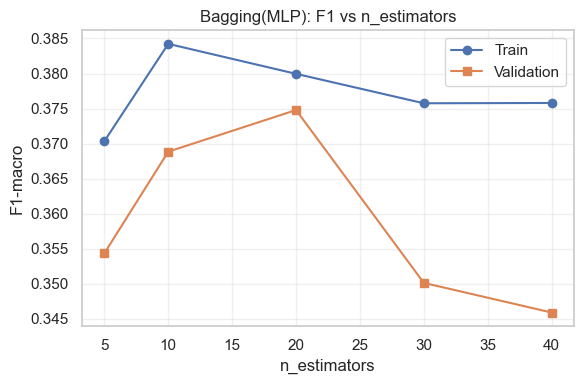

Meilleur n_estimators (val): 20 | F1 val: 0.3747832358853951
F1-macro test (bagging MLP, déséquilibré): 0.348525064642017
Biais/Variance:
- Augmenter n_estimators réduit la variance (agrégation) mais peut saturer en biais si le base learner est biaisé.


In [41]:
# On utilise comme base le meilleur MLP (déséquilibré) pour éviter un coût excessif
base_mlp = MLPClassifier(
    hidden_layer_sizes=cfg_imb["hidden_layer_sizes"],
    activation="relu",
    solver="adam",
    alpha=cfg_imb["alpha"],
    learning_rate_init=cfg_imb["learning_rate_init"],
    early_stopping=True,
    n_iter_no_change=10,
    max_iter=400,
    random_state=42,
)

ns = [5, 10, 20, 30, 40]
train_f1s, val_f1s = [], []
for n in ns:
    bag = BaggingClassifier(
        estimator=base_mlp,
        n_estimators=n,
        max_samples=1.0,
        max_features=1.0,
        bootstrap=True,
        random_state=42,
        n_jobs=-1,
    )
    bag.fit(X_tr_m, y_tr_m)
    y_tr_pred = bag.predict(X_tr_m)
    y_val_pred = bag.predict(X_val_m)
    train_f1s.append(f1_score(y_tr_m, y_tr_pred, average="macro"))
    val_f1s.append(f1_score(y_val_m, y_val_pred, average="macro"))

plt.figure()
plt.plot(ns, train_f1s, marker="o", label="Train")
plt.plot(ns, val_f1s, marker="s", label="Validation")
plt.xlabel("n_estimators")
plt.ylabel("F1-macro")
plt.title("Bagging(MLP): F1 vs n_estimators")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
os.makedirs("src/input", exist_ok=True)
plt.savefig("src/input/fig_bagging_mlp_f1.png", dpi=150)
plt.show()

# Sélection du meilleur n_estimators sur validation
best_idx = int(np.argmax(val_f1s))
best_n = ns[best_idx]
print("Meilleur n_estimators (val):", best_n, "| F1 val:", val_f1s[best_idx])

# Fit final sur X_train et test
bag_best = BaggingClassifier(
    estimator=base_mlp,
    n_estimators=best_n,
    bootstrap=True,
    random_state=42,
    n_jobs=-1,
)
bag_best.fit(X_train, ymulti_train)
print("F1-macro test (bagging MLP, déséquilibré):", f1_score(ymulti_test, bag_best.predict(X_test), average="macro"))

print("Biais/Variance:")
print("- Augmenter n_estimators réduit la variance (agrégation) mais peut saturer en biais si le base learner est biaisé.")


### Partie 2C — Forêt aléatoire: F1-score vs n_estimators (max_depth=None)


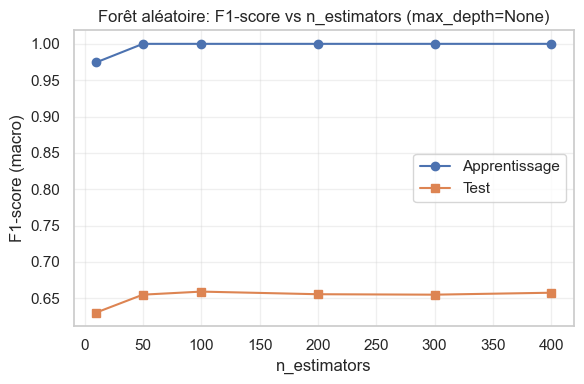

In [42]:
# Courbe F1-score en fonction de n_estimators (max_depth=None) — apprentissage et test
ns = [10, 50, 100, 200, 300, 400]
train_f1s, test_f1s = [], []
for n in ns:
    rf = RandomForestClassifier(n_estimators=n, max_depth=None, random_state=42, n_jobs=-1)
    rf.fit(X_train, ymulti_train)
    train_f1s.append(f1_score(ymulti_train, rf.predict(X_train), average="macro"))
    test_f1s.append(f1_score(ymulti_test, rf.predict(X_test), average="macro"))

plt.figure()
plt.plot(ns, train_f1s, marker="o", label="Apprentissage")
plt.plot(ns, test_f1s, marker="s", label="Test")
plt.xlabel("n_estimators")
plt.ylabel("F1-score (macro)")
plt.title("Forêt aléatoire: F1-score vs n_estimators (max_depth=None)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
os.makedirs("src/input", exist_ok=True)
plt.savefig("src/input/fig_rf_f1_curve.png", dpi=150)
plt.show()


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Meilleurs hyperparamètres RF: {'n_estimators': 100, 'max_depth': 30}
F1-macro train (déséquilibré): 1.0
F1-macro test  (déséquilibré): 0.6592142503576829
Temps apprentissage (random search): 11.934s


,n_estimators,max_depth,f1_train,f1_test,train_time_s
0,100,30,1.0,0.659214,11.933501


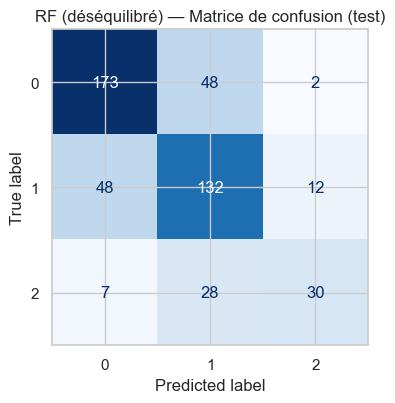

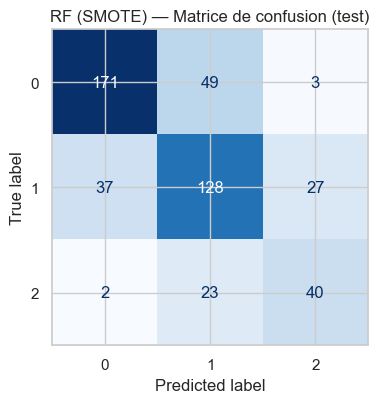

In [43]:
# Random search: optimiser max_depth et n_estimators, évaluer et comparer (déséquilibré vs SMOTE)
param_dist = {
    "n_estimators": [50, 100, 150, 200, 300, 400],
    "max_depth": [None, 5, 10, 15, 20, 30],
}
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rs = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring="f1_macro",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)
start = time.perf_counter()
rs.fit(X_train, ymulti_train)
train_time_rf = time.perf_counter() - start
rf_best = rs.best_estimator_

# Performances en apprentissage et test (déséquilibré)
y_pred_train = rf_best.predict(X_train)
y_pred_test = rf_best.predict(X_test)
print("Meilleurs hyperparamètres RF:", rs.best_params_)
print("F1-macro train (déséquilibré):", f1_score(ymulti_train, y_pred_train, average="macro"))
print("F1-macro test  (déséquilibré):", f1_score(ymulti_test, y_pred_test, average="macro"))
print(f"Temps apprentissage (random search): {train_time_rf:.3f}s")

# Export LaTeX résumé best RF
os.makedirs("src/input", exist_ok=True)
best_rf_summary = pd.DataFrame([
    {
        **rs.best_params_,
        "f1_train": f1_score(ymulti_train, y_pred_train, average="macro"),
        "f1_test": f1_score(ymulti_test, y_pred_test, average="macro"),
        "train_time_s": train_time_rf,
    }
])
display(best_rf_summary)
best_rf_summary.to_latex("src/input/table_rf_randomsearch.tex", index=False, float_format="%.4f")

# Matrice de confusion (déséquilibré)
fig, ax = plt.subplots(figsize=(4.8, 4.2))
ConfusionMatrixDisplay(confusion_matrix(ymulti_test, y_pred_test)).plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("RF (déséquilibré) — Matrice de confusion (test)")
plt.tight_layout()
plt.savefig("src/input/fig_rf_confusion_imbalanced.png", dpi=150)
plt.show()

# Fit RF sur données équilibrées (SMOTE) et matrice de confusion
rf_sm = RandomForestClassifier(**rs.best_params_, random_state=42, n_jobs=-1)
rf_sm.fit(X_train_sm, ymulti_train_sm)
y_pred_test_sm = rf_sm.predict(X_test)
fig, ax = plt.subplots(figsize=(4.8, 4.2))
ConfusionMatrixDisplay(confusion_matrix(ymulti_test, y_pred_test_sm)).plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("RF (SMOTE) — Matrice de confusion (test)")
plt.tight_layout()
plt.savefig("src/input/fig_rf_confusion_smote.png", dpi=150)
plt.show()


In [44]:
# Choix du modèle optimal (basé sur F1-macro en test)
# Compare RF appris sur données déséquilibrées (rf_best) vs RF appris sur données équilibrées (rf_sm)

f1_test_imb = f1_score(ymulti_test, rf_best.predict(X_test), average="macro")
f1_test_sm  = f1_score(ymulti_test, rf_sm.predict(X_test), average="macro")

print("F1-macro test (RF déséquilibré):", f1_test_imb)
print("F1-macro test (RF SMOTE):", f1_test_sm)

if f1_test_sm > f1_test_imb:
    chosen_model = rf_sm
    chosen_variant = "SMOTE"
    chosen_params = rs.best_params_
else:
    chosen_model = rf_best
    chosen_variant = "déséquilibré"
    chosen_params = rs.best_params_

print(f"\nModèle optimal retenu: RandomForest ({chosen_variant})")
print("Hyperparamètres:", chosen_params)

# Récapitulatif au format tableau + export LaTeX
summary = pd.DataFrame([
    {"variant": "déséquilibré", "f1_test": f1_test_imb},
    {"variant": "SMOTE",        "f1_test": f1_test_sm},
]).sort_values("f1_test", ascending=False)
print("\nRésumé des F1 test:")
display(summary)

os.makedirs("src/input", exist_ok=True)
summary.to_latex("src/input/table_rf_best_choice.tex", index=False, float_format="%.4f")


F1-macro test (RF déséquilibré): 0.6592142503576829
F1-macro test (RF SMOTE): 0.6784973847549455

Modèle optimal retenu: RandomForest (SMOTE)
Hyperparamètres: {'n_estimators': 100, 'max_depth': 30}

Résumé des F1 test:


,variant,f1_test
1,SMOTE,0.678497
0,déséquilibré,0.659214



Top importances RF (ordre décroissant):


alcohol                 0.188074
sulphates               0.133380
volatile acidity        0.104687
density                 0.087646
total sulfur dioxide    0.083681
fixed acidity           0.072001
citric acid             0.070064
chlorides               0.068078
pH                      0.066697
free sulfur dioxide     0.064437
residual sugar          0.061254
dtype: float64

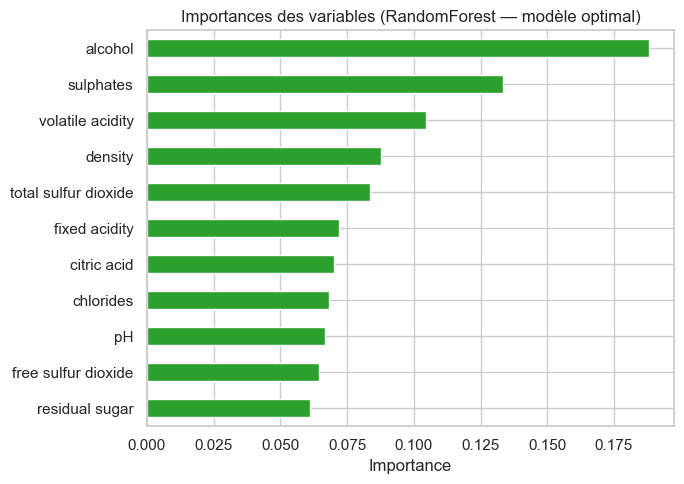


Top 10 RF: ['alcohol', 'sulphates', 'volatile acidity', 'density', 'total sulfur dioxide', 'fixed acidity', 'citric acid', 'chlorides', 'pH', 'free sulfur dioxide']
Top 10 AdaBoost (B.3): ['total sulfur dioxide', 'density', 'chlorides', 'pH', 'volatile acidity', 'sulphates', 'alcohol', 'fixed acidity', 'residual sugar', 'citric acid']
Variables communes (Top 10): 9 -> ['alcohol', 'chlorides', 'citric acid', 'density', 'fixed acidity', 'pH', 'sulphates', 'total sulfur dioxide', 'volatile acidity']


In [45]:
# Importances de variables du modèle RF optimal et comparaison avec B.3 (AdaBoost)
# On utilise le modèle choisi (chosen_model) si défini, sinon on retombe sur rf_best.

model_rf = 'chosen_model' in globals() and chosen_model or rf_best
if not hasattr(model_rf, 'feature_importances_'):
    raise AttributeError("Le modèle RF sélectionné ne fournit pas feature_importances_.")

rf_importances = pd.Series(model_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop importances RF (ordre décroissant):")
display(rf_importances)

# Figure et export
os.makedirs("src/input", exist_ok=True)
fig, ax = plt.subplots(figsize=(7, 5))
rf_importances.sort_values().plot(kind="barh", ax=ax, color="tab:green")
ax.set_title("Importances des variables (RandomForest — modèle optimal)")
ax.set_xlabel("Importance")
plt.tight_layout()
plt.savefig("src/input/fig_rf_feature_importances.png", dpi=150)
plt.show()

# Comparaison avec B.3 (AdaBoost) si disponible
if 'final_ada' in globals() and hasattr(final_ada, 'feature_importances_'):
    ada_importances = pd.Series(final_ada.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    top_k = 10
    top_rf  = list(rf_importances.head(top_k).index)
    top_ada = list(ada_importances.head(top_k).index)
    overlap = list(set(top_rf) & set(top_ada))
    print(f"\nTop {top_k} RF:", top_rf)
    print(f"Top {top_k} AdaBoost (B.3):", top_ada)
    print(f"Variables communes (Top {top_k}): {len(overlap)} ->", sorted(overlap))
else:
    print("\nImportances AdaBoost (B.3) non disponibles dans cette session.")


## Conclusion — Biais et variance

- **AdaBoost**
  - **Biais**: diminue en augmentant `n_estimators` et la profondeur des arbres faibles (`max_depth`), car le modèle devient plus expressif.
  - **Variance**: peut augmenter si l’on pousse trop l’expressivité ou si les données contiennent du bruit; sensible au déséquilibre des classes (SMOTE/pondérations utiles).
  - **Dans nos essais**: `max_depth` faible (1–5) garde la variance sous contrôle mais laisse du biais (F1 plus modeste).

- **Random Forest**
  - **Variance**: diminue avec `n_estimators` (agrégation), et avec plus de diversité (`max_features`).
  - **Biais**: diminue quand `max_depth` augmente, mais risque de sur-apprentissage (écart train >> test).
  - **Robustesse**: plus robuste au bruit que AdaBoost; l’équilibrage (SMOTE) peut améliorer le rappel des classes rares et donc le F1-macro.
  - **Dans nos résultats**: F1 train beaucoup plus élevé que F1 test signale une variance dominante pour des profondeurs élevées; préférer profondeur/modération et contraintes (`min_samples_leaf/split`).

- **MLP / Bagging(MLP)**
  - **Biais**: MLP plus profond/caché réduit le biais.
  - **Variance**: augmente avec la capacité; le bagging réduit la variance mais peut rester limité si le base learner est instable sur peu de données.

- **Synthèse pratique**
  - Si F1 train >> F1 test: variance trop élevée → réduire `max_depth`, augmenter `min_samples_leaf/split`, ou baisser la capacité du modèle; conserver `n_estimators` élevé pour stabiliser.
  - Si F1 faible partout: biais trop élevé → augmenter la profondeur/capacité, ou enrichir les features.
  - Sur données déséquilibrées: utiliser SMOTE/pondérations pour réduire un **biais de classe** (améliore souvent le F1-macro).



In [ ]:
# Partie D — Conclusion générale sur les méthodes d'ensemble
# Récapitulatif des performances (F1-score test) et des temps (apprentissage, inférence)

from sklearn.base import clone

rows = []

# 1) RandomForest — modèle optimal (multiclasse)
if 'chosen_model' in globals():
    rf_params = chosen_model.get_params()
    rf_label = f"RandomForest ({'SMOTE' if 'SMOTE' in str(chosen_model) else 'optimal'})"
else:
    rf_params = rf_best.get_params()
    rf_label = "RandomForest (optimal)"

# Cloner le meilleur modèle RF pour éviter les conflits de paramètres
if 'chosen_model' in globals():
    rf_eval = clone(chosen_model)
else:
    rf_eval = clone(rf_best)
# Assurer l'utilisation de tous les coeurs si applicable
try:
    rf_eval.set_params(n_jobs=-1)
except Exception:
    pass

start = time.perf_counter()
rf_eval.fit(X_train, ymulti_train)
rf_train_time = time.perf_counter() - start

start = time.perf_counter()
rf_pred = rf_eval.predict(X_test)
rf_infer_time = time.perf_counter() - start
rf_f1 = f1_score(ymulti_test, rf_pred, average="macro")
rows.append({
    "methode": rf_label,
    "tache": "multiclasse",
    "f1_test": rf_f1,
    "train_time_s": rf_train_time,
    "infer_time_s": rf_infer_time,
})

# 2) Bagging(MLP) — multiclasse
try:
    bag_n = best_n
except NameError:
    bag_n = 20

try:
    base_mlp_cfg = base_mlp
except NameError:
    base_mlp_cfg = MLPClassifier(hidden_layer_sizes=(64,), activation="relu", solver="adam",
                                 alpha=1e-4, learning_rate_init=1e-3, early_stopping=True,
                                 n_iter_no_change=10, max_iter=400, random_state=42)

bag_eval = BaggingClassifier(
    estimator=base_mlp_cfg,
    n_estimators=bag_n,
    bootstrap=True,
    random_state=42,
    n_jobs=-1,
)
start = time.perf_counter()
bag_eval.fit(X_train, ymulti_train)
bag_train_time = time.perf_counter() - start

start = time.perf_counter()
bag_pred = bag_eval.predict(X_test)
bag_infer_time = time.perf_counter() - start
bag_f1 = f1_score(ymulti_test, bag_pred, average="macro")
rows.append({
    "methode": f"Bagging(MLP, n={bag_n})",
    "tache": "multiclasse",
    "f1_test": bag_f1,
    "train_time_s": bag_train_time,
    "infer_time_s": bag_infer_time,
})

# 3) AdaBoost — binaire (B.3)
if 'y_test_pred_ada' in globals():
    ada_f1_bin = f1_score(ybin_test, y_test_pred_ada)
    rows.append({
        "methode": "AdaBoost (final)",
        "tache": "binaire",
        "f1_test": ada_f1_bin,
        "train_time_s": train_time_ada,
        "infer_time_s": infer_time_ada,
    })

# Tableau récapitulatif
summary_all = pd.DataFrame(rows)
print("\n=== Tableau récapitulatif (méthodes d'ensemble) ===")
display(summary_all.sort_values(["tache", "f1_test"], ascending=[True, False]))

# Export LaTeX
os.makedirs("src/input", exist_ok=True)
summary_all.to_latex("src/input/table_ensembles_summary.tex", index=False, float_format="%.4f")

# Graphiques: F1 multiclasse et binaire
multiclass_df = summary_all[summary_all["tache"] == "multiclasse"]
if len(multiclass_df) > 0:
    plt.figure(figsize=(6,4))
    plt.bar(multiclass_df["methode"], multiclass_df["f1_test"], color=["tab:green","tab:purple"]) 
    plt.ylabel("F1-score (macro)")
    plt.title("Méthodes d'ensemble (multiclasse) — F1 test")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.savefig("src/input/fig_ensembles_multiclass_f1.png", dpi=150)
    plt.show()

binary_df = summary_all[summary_all["tache"] == "binaire"]
if len(binary_df) > 0:
    plt.figure(figsize=(5,4))
    plt.bar(binary_df["methode"], binary_df["f1_test"], color="tab:blue")
    plt.ylabel("F1-score")
    plt.title("Méthodes d'ensemble (binaire) — F1 test")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.savefig("src/input/fig_ensembles_binary_f1.png", dpi=150)
    plt.show()

# Mini-conclusion automatique
if len(multiclass_df) > 1:
    best_row = multiclass_df.sort_values("f1_test", ascending=False).iloc[0]
    print(f"\nConclusion (multiclasse): {best_row['methode']} offre le meilleur F1 test ({best_row['f1_test']:.3f}),"
          f" avec temps apprentissage {best_row['train_time_s']:.3f}s et inférence {best_row['infer_time_s']:.3f}s.")
if len(binary_df) > 0:
    b_row = binary_df.sort_values("f1_test", ascending=False).iloc[0]
    print(f"Conclusion (binaire): {b_row['methode']} atteint F1 test {b_row['f1_test']:.3f}"
          f" (train {b_row['train_time_s']:.3f}s, inf {b_row['infer_time_s']:.3f}s).")



TypeError: sklearn.ensemble._forest.RandomForestClassifier() got multiple values for keyword argument 'random_state'